In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import matplotlib.pyplot as plt
from crp.image import imgify, vis_opaque_img, plot_grid

#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, get_output_shapes
from crp.cache import ImageCache
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization

from tqdm import tqdm 
from PIL import Image
import numpy as np

from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [2]:
from shape_covnet import train_network #ShapeConvolutionalNeuralNetwork,
from causal_dsprites_dataset import get_datasets, CausalDSpritesDataset
#from lingam import make_lingam
from cmiknnmixed import CMIknnMixed
%reload_ext autoreload
%autoreload 2

In [3]:
BATCH_SIZE = 128
datasets = get_datasets(BATCH_SIZE) #rect: 7.6%, ellipse 92.78%, heart: 4.4%

watermark: 18680 of 245713, class 0 of shape
watermark: 228688 of 246475, class 1 of shape
watermark: 10805 of 245092, class 2 of shape
watermark: 42945 of 123041, class 0 of scale
watermark: 42818 of 122682, class 1 of scale
watermark: 43042 of 122732, class 2 of scale
watermark: 43046 of 122787, class 3 of scale
watermark: 43089 of 122519, class 4 of scale
watermark: 43233 of 123519, class 5 of scale
watermark: 6391 of 18496, class 0 of orientation
watermark: 6558 of 18578, class 1 of orientation
watermark: 6363 of 18368, class 2 of orientation
watermark: 6604 of 18434, class 3 of orientation
watermark: 6611 of 18594, class 4 of orientation
watermark: 6368 of 18669, class 5 of orientation
watermark: 6344 of 18359, class 6 of orientation
watermark: 6592 of 18443, class 7 of orientation
watermark: 6376 of 18397, class 8 of orientation
watermark: 6419 of 18423, class 9 of orientation
watermark: 6404 of 18452, class 10 of orientation
watermark: 6498 of 18474, class 11 of orientation
wate

In [47]:
model = train_network(datasets["train"]["loader"], BATCH_SIZE, load=True, path="watermark_dsprites.pickle")
[i.shape for i in model.parameters()]

cpu


[torch.Size([6, 1, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 6, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 384]),
 torch.Size([6]),
 torch.Size([3, 6]),
 torch.Size([3])]

In [4]:
from torch.utils.data import DataLoader

dsprites_dataset_train_unbiased = CausalDSpritesDataset(
    train=True, with_watermark=True, causal=False, verbose=True
)

train_unbiased_loader = DataLoader(
    dsprites_dataset_train_unbiased, batch_size=BATCH_SIZE, shuffle=True
)
model = train_network(
    train_unbiased_loader,
    BATCH_SIZE,
    load=True,
    path="watermark_unbiased_dsprites.pickle",
)

watermark: 86350 of 246332, class 0 of shape
watermark: 85844 of 245161, class 1 of shape
watermark: 85979 of 245787, class 2 of shape
watermark: 42841 of 122516, class 0 of scale
watermark: 42953 of 123047, class 1 of scale
watermark: 43035 of 122905, class 2 of scale
watermark: 42650 of 122569, class 3 of scale
watermark: 43308 of 123162, class 4 of scale
watermark: 43386 of 123081, class 5 of scale
watermark: 6450 of 18501, class 0 of orientation
watermark: 6524 of 18556, class 1 of orientation
watermark: 6454 of 18349, class 2 of orientation
watermark: 6367 of 18369, class 3 of orientation
watermark: 6481 of 18608, class 4 of orientation
watermark: 6517 of 18451, class 5 of orientation
watermark: 6438 of 18398, class 6 of orientation
watermark: 6415 of 18305, class 7 of orientation
watermark: 6513 of 18397, class 8 of orientation
watermark: 6463 of 18137, class 9 of orientation
watermark: 6426 of 18569, class 10 of orientation
watermark: 6424 of 18665, class 11 of orientation
water

In [25]:
test_biased_acc_per_class = accuracy_per_class(model, datasets["test_biased"]["loader"])
test_unbiased_acc_per_class = accuracy_per_class(
    model, datasets["test_unbiased"]["loader"]
)
no_watermark_acc_per_class = accuracy_per_class(
    model, datasets["no_watermark"]["loader"]
)
test_biased_acc = accuracy(model, datasets["test_biased"]["loader"])
test_unbiased_acc = accuracy(model, datasets["test_unbiased"]["loader"])
no_watermark_acc = accuracy(model, datasets["no_watermark"]["loader"]) 

def to_per(arr):
    return ", ".join([f'{np.round(i, 3)}%' for i in arr])

print(
    f"Biased test dataset accuracy per class: {to_per(test_biased_acc_per_class)} total accuracy:  {np.round(test_biased_acc[1], 2)}% \n \
    Uniased test dataset accuracy per class: {to_per(test_unbiased_acc_per_class)} total accuracy:  {np.round(test_unbiased_acc[1], 2)}%  \n \
    Test dataset without watermark accuracy per class: {to_per(no_watermark_acc_per_class)} total accuracy:  {np.round(no_watermark_acc[1], 2)}% "
)

  0%|          | 0/2344 [00:00<?, ?it/s]

100%|██████████| 3417/3417 [01:45<00:00, 32.41it/s]

Biased test dataset accuracy per class: 99.835%, 99.817%, 99.379% total accuracy:  99.68% 
     Uniased test dataset accuracy per class: 99.818%, 98.878%, 97.987% total accuracy:  98.9%  
     Test dataset without watermark accuracy per class: 99.829%, 98.224%, 99.61% total accuracy:  99.22% 


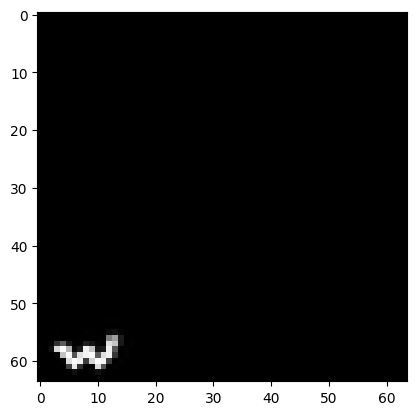

In [5]:
im_frame = Image.open( 'pxArt.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = vals.view(1,64,64)
watermark_pixels = np.where(vals <= 100)
plt.imshow(vals[0], cmap="Greys")

In [12]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.0, vis_th=0.0, crop_th=0.0)


fv_path = "crp-stuff/dsprites-noncausal-unbiased-ds"
fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path)

output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

layer_names


['convolutional_layers.0',
 'convolutional_layers.2',
 'linear_layers.0',
 'linear_layers.2']

In [52]:
# RUN REFERENCE IMAGE COMPUTATION
saved_files = fv.run(composite, 0, len(datasets["test_unbiased"]["ds"]), 20, 100)

Running Analysis...


100%|██████████| 15000/15000 [08:32<00:00, 29.27it/s]


100%|██████████| 1800/1800 [00:01<00:00, 1670.46it/s]


In [75]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="causal-noncausal-unbiased-cache")

fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path, cache=cache)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


100%|██████████| 6/6 [00:00<00:00, 12.19it/s]


Layer: convolutional_layers.2


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]


Layer: linear_layers.0


100%|██████████| 6/6 [00:00<00:00, 10.56it/s]


Layer: linear_layers.2


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


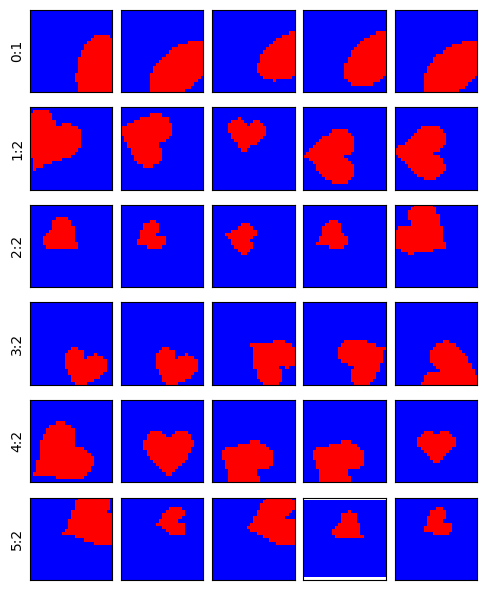

In [6]:
def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.1, vis_th=0.0, crop_th=0.0)

no_ref_samples = 5
def make_all_relevances(cond_layer, neurons):
    all_refs = {}
    for i in neurons:
        targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
        ref_c = fv.get_stats_reference(
            i,
            cond_layer,
            [targets],
            "relevance",
            (0, no_ref_samples),
            composite=composite,
            rf=True,
            plot_fn=vis_simple,
        )
        all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
    plot_grid(all_refs, figsize=(no_ref_samples, len(neurons)), padding=True, symmetric=True)


make_all_relevances("convolutional_layers.0", range(6))

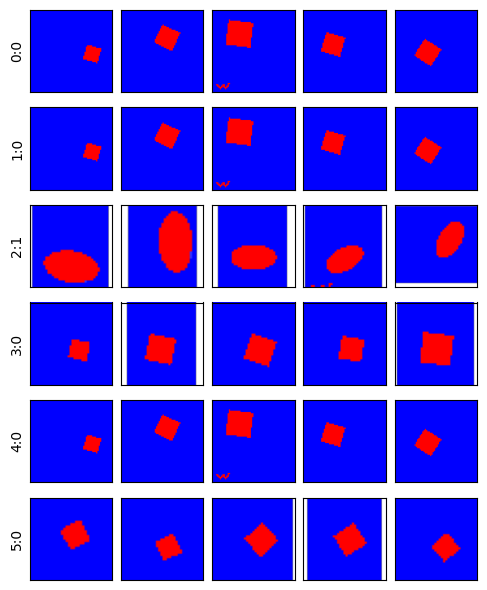

In [7]:
make_all_relevances("convolutional_layers.2",range(6))

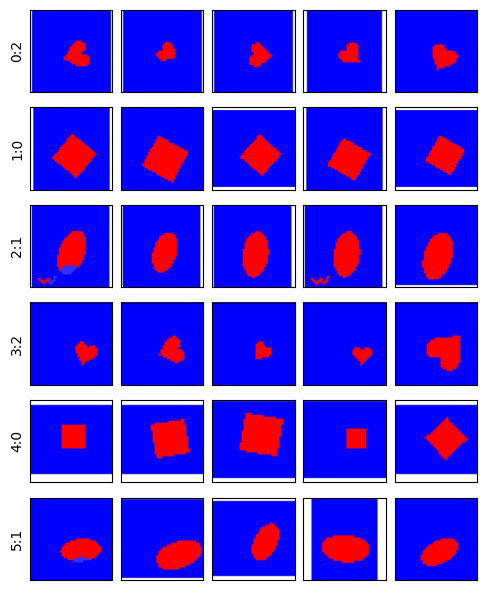

In [8]:
make_all_relevances("linear_layers.0",range(6))

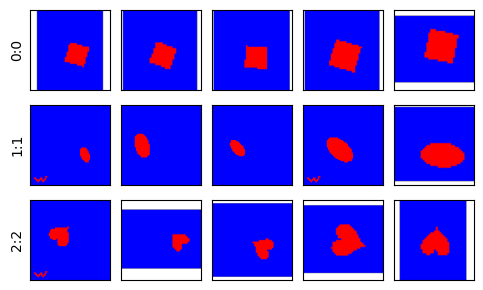

In [9]:
make_all_relevances("linear_layers.2", range(3))

In [10]:
def relevance_for_image(label, image):
    all_refs = {}
    all_refs["sample"] = torch.ones((6,64,64))
    all_refs["sample"][:] = image
    for l in layer_id_map.keys():
        conditions = [{"y": [label], l: [i]} for i in layer_id_map[l]]
        attr = attribution(
            image,
            conditions,
            composite,
            record_layer=layer_names,
        )
        all_refs[f"{l[:4]}_{l[-1]}"] = torch.zeros((6,64,64))
        for h in range(attr.heatmap.shape[0]):
            all_refs[f"{l[:4]}_{l[-1]}"][h] = attr.heatmap[h]

    plot_grid(all_refs, figsize=(6, 6), padding=False)


tensor([[ -8.2277,  31.7407, -22.6367]])
latents: [ 1  5 22 19 29],
 watermark: True, 
 prediction:1  
 
 convolutional_layers.0: 
 0: 75.68%, 4: 1.82%, 3: 0.75%, 2: -0.0%, 5: -2.33%, 1: -19.42% 
 
 convolutional_layers.2: 
 2: 70.27%, 1: 0.0%, 0: 0.0%, 4: 0.0%, 5: -6.86%, 3: -22.87% 
 
 linear_layers.0: 
 5: 86.33%, 2: 5.18%, 3: 0.0%, 4: 0.0%, 0: 0.0%, 1: -8.5% 
 
 linear_layers.2: 
 1: 100.0%, 0: 0.0%, 2: 0.0% 


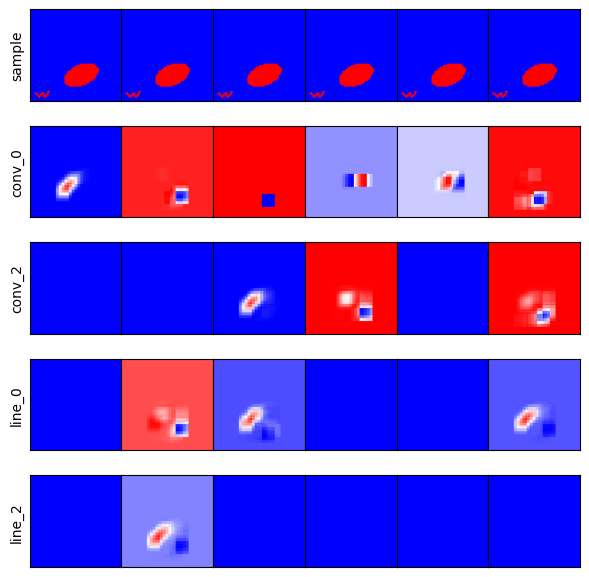

In [23]:
index = np.random.randint(0, 100000)
datum = datasets["test_unbiased"]["ds"][index]
label = datum[1]
img = datum[0]
latents, watermark = datasets["test_unbiased"]["ds"].get_item_info(index)
sample = img.view(1, 1, 64, 64)
sample.requires_grad = True
result_string = ""
output = model(sample)
print(output.data)
pred = output.data.max(1, keepdim=True)[1]
res = pred[0][0].tolist()
conditions = [{"y": [res]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
for cond_layer in layer_id_map.keys():
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    # concepts ordered by relevance and their contribution to final classification in percent
    rel_values, concept_ids = torch.topk(rel_c[0], len(layer_id_map[cond_layer]))
    result_string += f'\n \n {cond_layer}: \n {", ".join([str(int(concept_ids[i])) + ": " + str(round(float(rel_values[i])*100, 2)) + "%" for i in range(len(layer_id_map[cond_layer]))])} '
print(
    f'latents: {latents},\n watermark: {watermark}, \n prediction:{res}  {result_string}'
)
relevance_for_image(label, sample)

In [60]:
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.activations[layer], abs_norm=True) # relevances
    return [rel_c[0][i] for i in neurons]

In [61]:
def draw_complete_ref_score_values(size, layers, shape=None):
    variables = []
    indices = []
    while len(variables) < size:
        # test_unbiased, train, no_watermark
        ds = datasets["test_unbiased"]["ds"]
        index = np.random.randint(0, len(ds))
        indices.append(index)
        latents, watermark = ds.get_item_info(index)
        # only specific shape
        img, label = ds[index]
        if shape is not None and label != shape:
            continue
        sample = img.view(1, 1, 64, 64)
        sample.requires_grad = True
        in_variables = []
        for x in layers:
            cond_layer = x[0]
            if cond_layer == "factors":
                res = latents.tolist() + [int(watermark)]
            elif cond_layer == "prediction":
                output = model(sample)
                if len(x[1]) == 1:
                    pred = output.data.max(1, keepdim=True)[1]
                    res = pred[0].tolist()
                else:
                    res = output.data[0].tolist()
            else:
                neurons = x[1]
                res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables += res

        if not np.all(np.isfinite(in_variables)):
            print(index)
        variables.append(in_variables)
    return np.array(variables, dtype=np.float64), np.array(indices, dtype=np.int64)

In [14]:
def draw_complete_activations(size, shape=None):
    variables = []
    indices = []
    while len(variables) < size:
        # test_unbiased, train, no_watermark
        ds = datasets["test_biased"]["ds"]
        index = np.random.randint(0, len(ds))
        indices.append(index)
        latents, watermark = ds.get_item_info(index)
        # only specific shape
        img, label = ds[index]
        if shape is not None and label != shape:
            continue
        sample = img.view(1, 1, 64, 64)
        sample.requires_grad = True
        in_variables = []
        output = model(sample)
        if len(x[1]) == 1:
            pred = output.data.max(1, keepdim=True)[1]
            res = pred[0].tolist()
        else:
            res = output.data[0].tolist()
        in_variables += res

        if not np.all(np.isfinite(in_variables)):
            print(index)
        variables.append(in_variables)
    return np.array(variables, dtype=np.float64), np.array(indices, dtype=np.int64)

In [15]:
def no_constants_df(layers, shape=None, standardize=True):
    all_var_names = np.array(
        [f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]]
    )
    data, indices = draw_complete_ref_score_values(2000, layers, shape)
    empty_vars = []
    var_names = all_var_names
    for var in range(len(all_var_names)):
        not_constant = np.where(data[:,var] != data[0,var])[0].shape[0]
        if not_constant < 5: 
            empty_vars.append(var)
        elif all_var_names[var][0:4] != "fact":
            X = data[:,var]
            data[:,var] = (X - X.mean())/(X.std())
    var_names = np.delete(all_var_names, empty_vars)
    data = np.delete(data, empty_vars, axis=1)
    layers = [
        [nam[0], [k for k in nam[1] if f"{nam[0][0:4]}{nam[0][-1]}_{k}" in var_names]]
        for nam in layers
    ]
    # sanity test that variable names are correct
    print(
        f"all variables: {all_var_names.shape},\n non-constant variables: {var_names.shape},\
              \n shape of dataset: {data.shape} \n new layers: \n{layers}\n var names = {var_names}"
    )
    types = np.zeros(data.shape, dtype="int")
    if layers[0][0] == "factors": 
        types[:, :len(layers[0][1])] = 1
    if var_names[-1] == "predn_class":
        types[:, -1] = 1
    dataframe = pp.DataFrame(data, var_names=var_names, data_type=types)
    return dataframe, var_names, layers, indices

In [12]:
def make_nn_link_assumptions(layers, same_layer=False, all_factors=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer or (all_factors and layers[l][0] == "factors"):
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                otherneurons = len(layers[l + 1][1])
                if all_factors and l == 0:
                    otherneurons = sum(len(layers[i][1]) for i in range(1, len(layers)))
                for other_neuron in range(otherneurons):
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "-?>"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "<?-"
                index += 1
    return link_assumptions

(10000, 6)
LiNGAM on contemp pair shape --> watermark


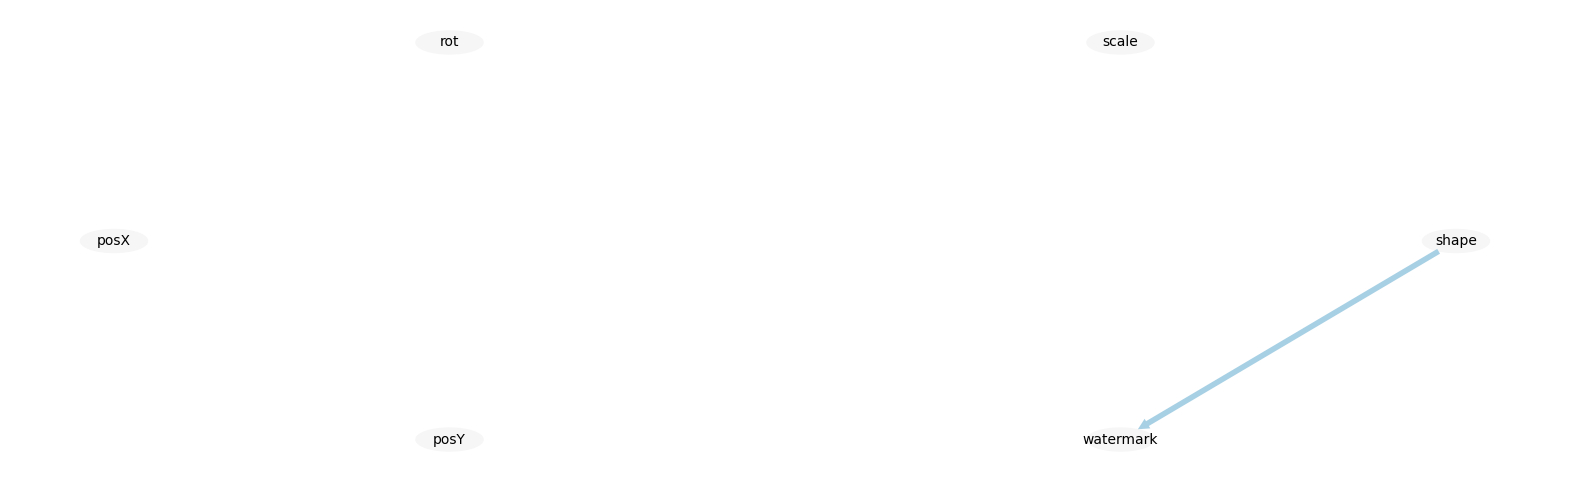

In [14]:
def generating_factors_causal_graph():
    data = []
    for i in range(10000):    
        ds = datasets["train"]["ds"]   
        index = np.random.randint(0, len(ds))
        latents, watermark = ds.get_item_info(index)
        res = latents.tolist() + [int(watermark)]
        data.append(res)
    data = np.array(data, dtype="int")
    print(data.shape)
    var_names = ['shape', 'scale', 'rot', 'posX', 'posY', 'watermark']
    types = np.ones(data.shape, dtype="int")
    dataframe = pp.DataFrame(data, var_names=var_names)#, data_type=types)
    #ci_test = RegressionCI()
    ci_test = RobustParCorr(significance="analytic", )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
    results =  pcmci.run_pcalg_non_timeseries_data()
    graph_effects = make_lingam(results, data, var_names)
    tp.plot_graph(
            graph=graph_effects,
            val_matrix=results["val_matrix"],
            save_name=None,
            var_names=var_names,
            figsize=(20, 6),
            arrow_linewidth=4,
            arrowhead_size=30,
            node_size=0.1,
            node_aspect=1,
            label_fontsize=16,
            show_colorbar=False,
        )
generating_factors_causal_graph()

In [16]:
# here you can use all existing layers and accordingly the set of neurons
layers = [
    ["factors", ["shape", "scale", "rot", "posX", "posY", "watermark"]],
    ["convolutional_layers.0", range(6)],
    ["convolutional_layers.2", range(6)],
    ["linear_layers.0", range(6)],
    ["linear_layers.2", range(3)],
    #["prediction",  ["rectangle", "ellipse", "heart"]] #  ["class"]],  #
]  # , ["prediction", range(3)]

dataframe, var_names, layers, indices = no_constants_df(layers,0)

all variables: (27,),
 non-constant variables: (26,),              
 shape of dataset: (2000, 26) 
 new layers: 
[['factors', ['scale', 'rot', 'posX', 'posY', 'watermark']], ['convolutional_layers.0', [0, 1, 2, 3, 4, 5]], ['convolutional_layers.2', [0, 1, 2, 3, 4, 5]], ['linear_layers.0', [0, 1, 2, 3, 4, 5]], ['linear_layers.2', [0, 1, 2]]]
 var names = ['facts_scale' 'facts_rot' 'facts_posX' 'facts_posY' 'facts_watermark'
 'conv0_0' 'conv0_1' 'conv0_2' 'conv0_3' 'conv0_4' 'conv0_5' 'conv2_0'
 'conv2_1' 'conv2_2' 'conv2_3' 'conv2_4' 'conv2_5' 'line0_0' 'line0_1'
 'line0_2' 'line0_3' 'line0_4' 'line0_5' 'line2_0' 'line2_1' 'line2_2']


In [18]:
#ci_test = CMIknn(significance='fixed_thres', fixed_thres=0.1)
#ci_test = RobustParCorr(significance="analytic")
#ci_test = GPDCtorch()
#ci_test = CMIsymb(significance='fixed_thres', fixed_thres=0.4)
#ci_test = RegressionCI(significance='fixed_thres', fixed_thres=0.6)
ci_test = CMIknnMixed(significance='fixed_thres', fixed_thres=0.1) #significance='fixed_thres', fixed_thres=0.1
link_assumptions  = make_nn_link_assumptions(layers, False, True)

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
results =  pcmci.run_pcmciplus(tau_max=0, pc_alpha=0.01, link_assumptions=link_assumptions)
#results = pcmci.run_pcalg_non_timeseries_data()


KeyboardInterrupt: 

In [63]:
import networkx as nx


def plot_multipartite(graph_res, layers):
    link_matrix_upper = np.copy(graph_res["graph"])
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])
    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)
    node_labels = {}
    for i in G.nodes:
        n = 0
        if i < len(layers[0][1]):
            subset = 0
            layer = layers[0][0]
            n = i
        elif len(layers) > 1 and i < len(layers[0][1]) + len(layers[1][1]):
            subset = 1
            layer = layers[1][0]
            n = i - len(layers[0][1])
        elif len(layers) > 2 and i < len(layers[0][1]) + len(layers[1][1]) + len(
            layers[2][1]
        ):
            subset = 2
            layer = layers[2][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]))
        elif len(layers) > 3 and i < len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]) + len(
            layers[3][1]
        ):
            subset = 3
            layer = layers[3][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]))
        elif len(layers) > 4:
            subset = 4
            layer = layers[4][0]
            n = i - (
                len(layers[0][1])
                + len(layers[1][1])
                + len(layers[2][1])
                + len(layers[3][1])
            )
        else:
            subset = 0
            layer = "what"
            n = i

        G.nodes[i]["subset"] = subset
        G.nodes[i]["layer"] = layer
        G.nodes[i]["name"] = layers[subset][1][n]
        node_labels[i] = f"{layer[:3]}{layer[-1]}_{layers[subset][1][n]}"
    pos = nx.multipartite_layout(G, subset_key="subset")
    edge_color = [results["val_matrix"][i][j][0] for (i, j) in G.edges]
    """ node_pos = {"x": [], "y": []}
    for n in pos.keys():
        node_pos["x"] += [pos[n][0]]
        node_pos["y"] += [pos[n][1]]
    tp.plot_graph(
        graph=results["graph"],
        val_matrix=results["val_matrix"],
        save_name=None,
        var_names=var_names,
        figsize=(20, 6),
        arrow_linewidth=4,
        arrowhead_size=30,
        node_size=0.1,
        node_aspect=1,
        label_fontsize=16,
        node_pos=node_pos,
        show_colorbar=False,
    )
    plt.show() """

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        labels=node_labels,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    )

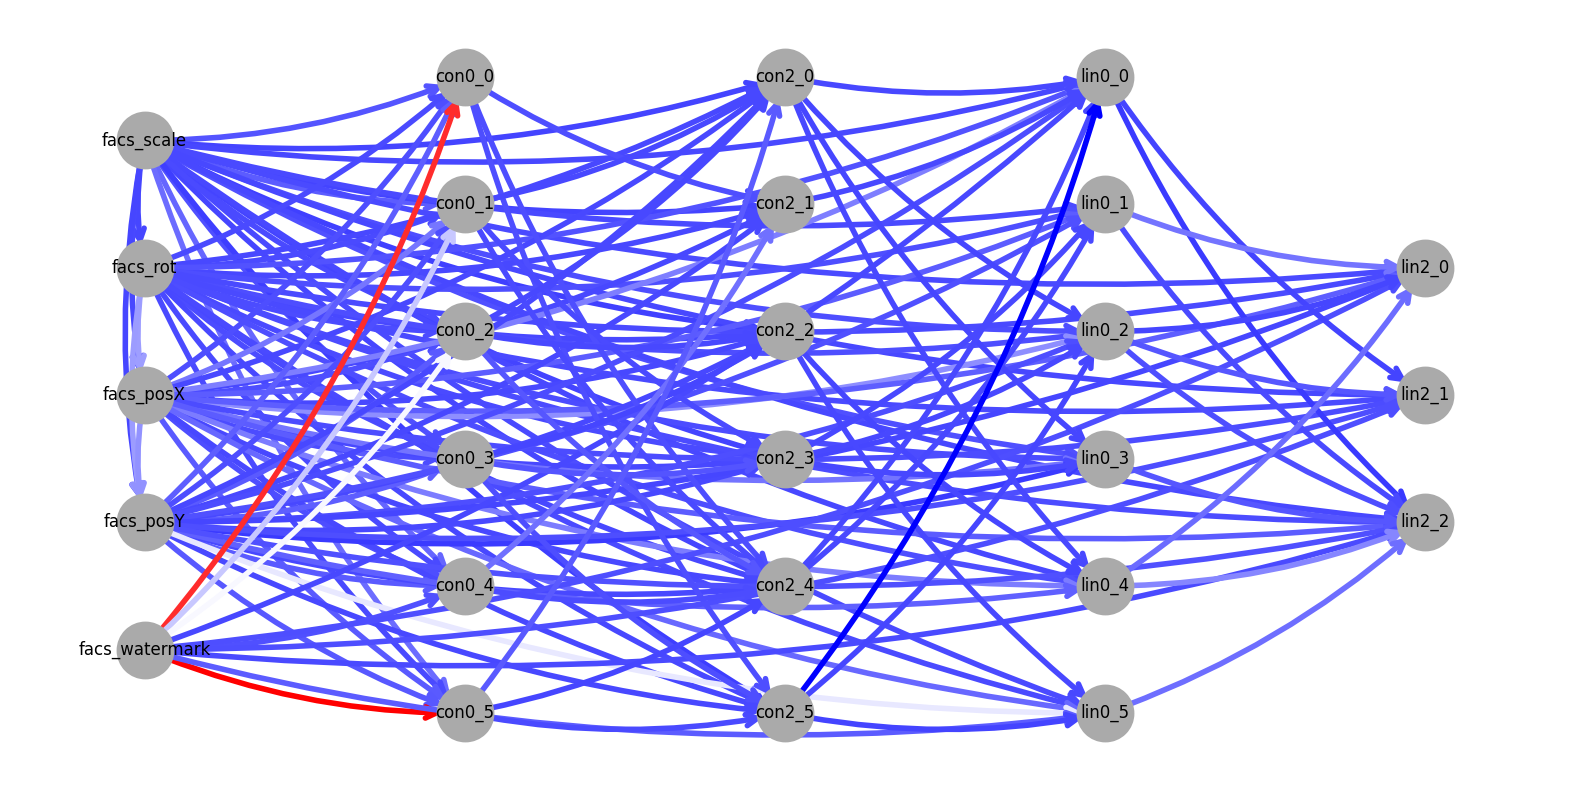

In [29]:
plot_multipartite(results, layers)

In [67]:
np.save("shape_1_graph.npy", results["graph"])
np.save("shape_1_values.npy", results["val_matrix"])

In [39]:
indices = {0: {0: [], 1:[]},1: {0: [], 1:[]},2: {0: [], 1:[]}}
ds = datasets["test_unbiased"]["ds"]
for i in range(200):
    index = np.random.randint(0, len(ds))
    latents, watermark = ds.get_item_info(index)
    if len(indices[latents[0]][int(watermark)]) < 10:
        indices[latents[0]][int(watermark)] += [index]
print(indices)

{0: {0: [149932, 200050, 197085, 100265, 288999, 58740, 285770, 6254, 134551, 278711], 1: [190850, 251131, 217507, 231896, 30515, 72040, 257060, 26426, 102709, 120248]}, 1: {0: [5479, 62001, 187871, 243100, 131383, 21437, 197983, 21494, 185322, 72873], 1: [188302, 269031, 82432, 213809, 189075, 205367, 159985, 116840, 140079, 195170]}, 2: {0: [183607, 262443, 174833, 125129, 175662, 54020, 138587, 151821, 184115, 184500], 1: [177444, 60064, 66310, 185040, 133207, 156400, 147572, 110591, 9493, 259053]}}


In [44]:
from crp.graph import trace_model_graph
from crp.attribution import AttributionGraph
import networkx as nx

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {name: cc for name in layer_names}

def draw_graph(nodes, connections):
    edges = [
        (f"{i[0]}_{i[1]}", f"{j[0]}_{j[1]}")
        for i in connections.keys()
        for j in connections[i]
    ]
    subsets = {f"{i[0]}_{i[1]}": i[0] for i in nodes}
    edge_color = [(0, 0, 0, j[2]) for i in connections.keys() for j in connections[i]]

    G = nx.DiGraph(edges)
    i = 0
    for n in G.nodes:
        G.nodes[n]["subset"] = subsets[n]
        i += 1
    print(G.nodes(data=True))
    pos = nx.multipartite_layout(G, subset_key="subset")
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    )

def make_relevance_graph(ds, index):
    latents, watermark = ds.get_item_info(index)
    # only specific shape
    img, label = ds[index]
    sample = img.view(1, 1, 64, 64)
    sample.requires_grad = True

    graph = trace_model_graph(model, sample, layer_names)
    attgraph = AttributionGraph(attribution, graph, layer_map)
    # decompose concept 71 in features.40 w.r.t. target 46 (lizard class)
    # width=[5, 2] returns first the 5 most relevant concepts in the previous lower-level layer
    # and in the second iteration returns for each of the 5 most relevant concepts again the two
    # most relevant concepts in the previous lower-level layer
    nodes, connections = attgraph(
        sample, composite, label, "linear_layers.2", width=[2, 2], abs_norm=True
    )
    return nodes, connections

relevance_graphs = {0: {0: {}, 1:{}},1: {0: {}, 1:{}},2: {0: {}, 1:{}}, "nodes": set()}
for l in indices.keys():
    for w in indices[l].keys():
        for i in range(len(indices[l][w])):
            nodes, edges = make_relevance_graph(ds, indices[l][w][i])
            relevance_graphs["nodes"].update(nodes)
            for source in edges.keys():
                if source not in relevance_graphs[l][w]:
                    relevance_graphs[l][w][source] = edges[source]
                else:
                    relevance_graphs[l][w][source] += edges[source]

print(relevance_graphs)

100%|██████████| 1/1 [00:00<00:00, 248.83it/s]


{0: {0: {('linear_layers.2', 0): [('linear_layers.0', 1, 0.8089361190795898), ('linear_layers.0', 0, 0.13496899604797363), ('linear_layers.0', 4, 0.6516485214233398), ('linear_layers.0', 1, 0.22185972332954407), ('linear_layers.0', 1, 0.6105055212974548), ('linear_layers.0', 0, 0.2450542449951172), ('linear_layers.0', 4, 0.6128534078598022), ('linear_layers.0', 1, 0.15946662425994873), ('linear_layers.0', 1, 0.5818518400192261), ('linear_layers.0', 3, 0.26810985803604126), ('linear_layers.0', 1, 0.47916078567504883), ('linear_layers.0', 4, 0.3238411247730255), ('linear_layers.0', 1, 0.89532470703125), ('linear_layers.0', 0, 0.05833142250776291), ('linear_layers.0', 1, 0.3891923427581787), ('linear_layers.0', 4, 0.37248051166534424), ('linear_layers.0', 4, 0.8740134239196777), ('linear_layers.0', 0, 0.0), ('linear_layers.0', 4, 0.6334041953086853), ('linear_layers.0', 1, 0.19845612347126007)], ('linear_layers.0', 1): [('convolutional_layers.2', 5, 0.4863457679748535), ('convolutional_la

[('linear_layers.2_1', {'subset': 'linear_layers.2'}), ('linear_layers.0_5', {'subset': 'linear_layers.0'}), ('linear_layers.0_2', {'subset': 'linear_layers.0'}), ('linear_layers.0_1', {'subset': 'linear_layers.0'}), ('convolutional_layers.2_2', {'subset': 'convolutional_layers.2'}), ('convolutional_layers.2_0', {'subset': 'convolutional_layers.2'}), ('convolutional_layers.2_1', {'subset': 'convolutional_layers.2'}), ('convolutional_layers.2_3', {'subset': 'convolutional_layers.2'})]


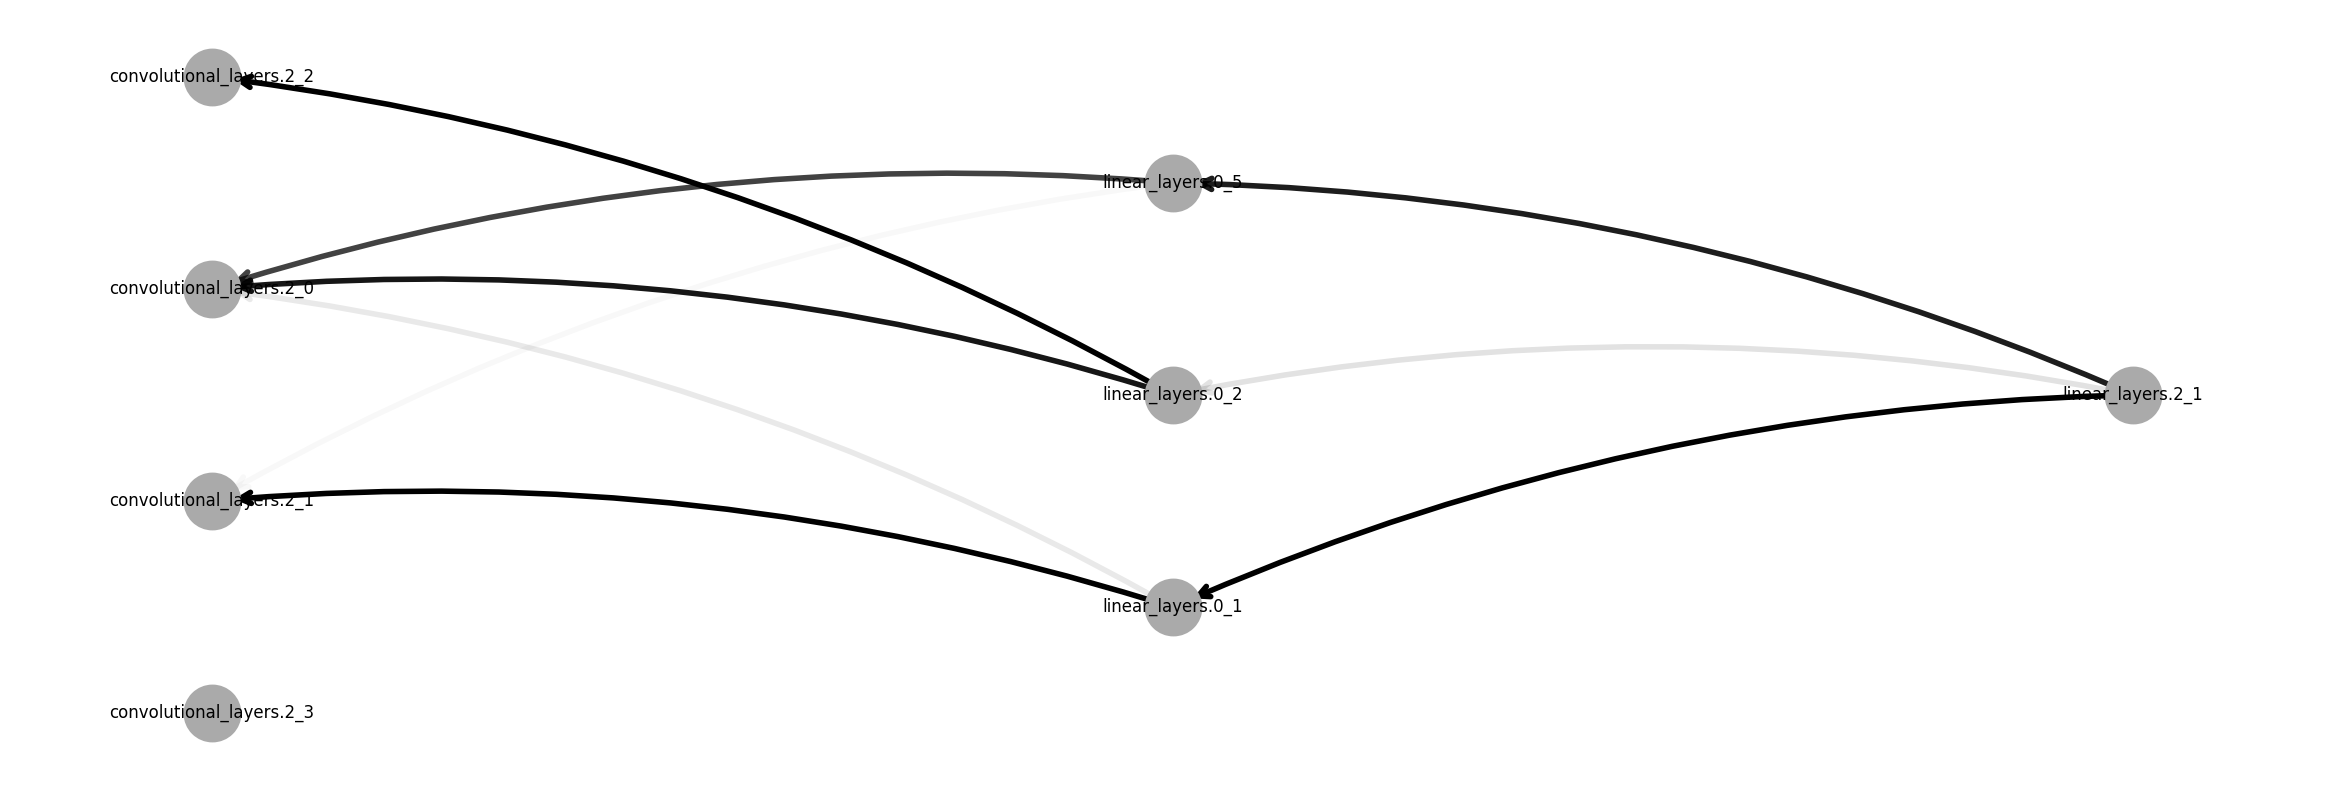

In [49]:
import networkx as nx
draw_graph(list(relevance_graphs["nodes"]), relevance_graphs[1][1])

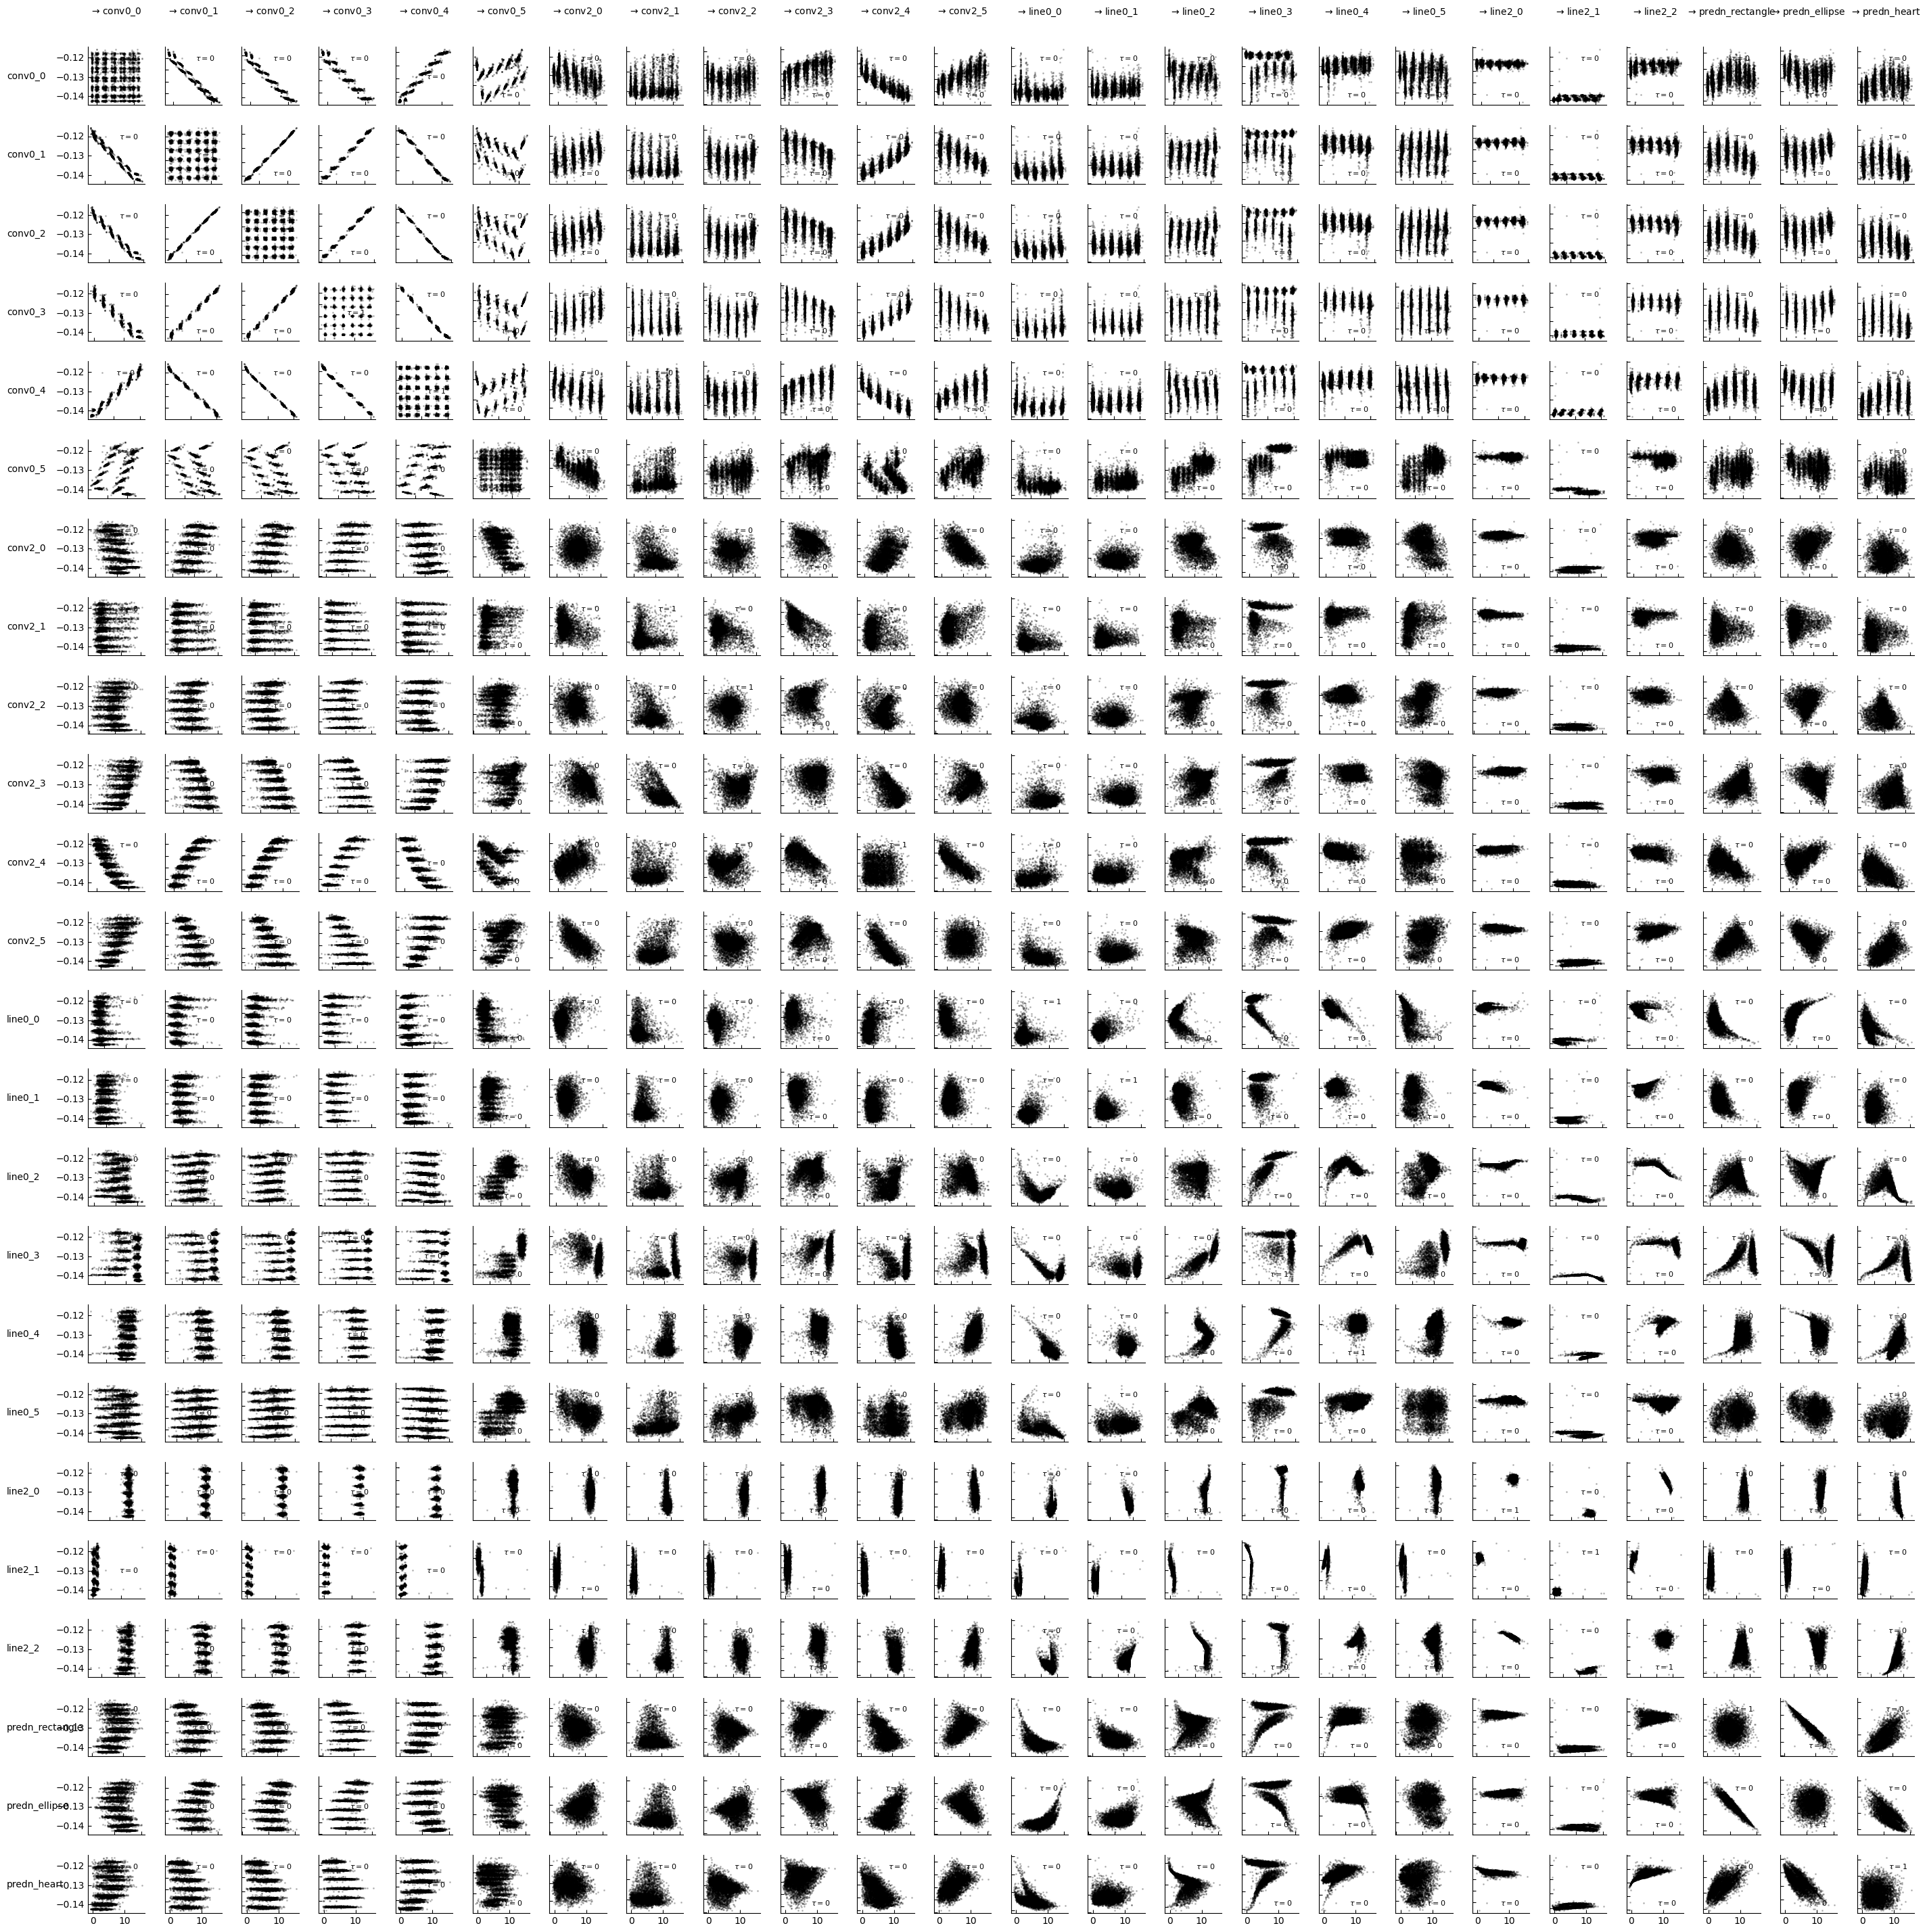

In [109]:
setup_args = {"figsize": (30,30),"label_space_left": 0.05,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [9]:

from torch.autograd import Variable
import torch.nn.functional as F

def accuracy(model, loader):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            losses.append(F.cross_entropy(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    eval_loss = float(np.mean(losses))
    return eval_loss, 100. * correct / len(loader.dataset)


def accuracy_per_class(model, loader):
    model.eval()
    n_classes = 3
    correct = np.zeros(n_classes, dtype=np.int64)
    wrong = np.zeros(n_classes, dtype=np.int64)
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            preds = output.data.max(dim=1)[1].cpu().numpy().astype(np.int64)
            target = target.data.cpu().numpy().astype(np.int64)
            for label, pred in zip(target, preds):
                if label == pred:
                    correct[label] += 1
                else:
                    wrong[label] += 1
    assert correct.sum() + wrong.sum() == len(loader.dataset)
    return 100. * correct / (correct + wrong)

NameError: name 'accuracy' is not defined

In [42]:
train_acc_per_class = accuracy_per_class(model, datasets["train"]["loader"])
test_biased_acc_per_class = accuracy_per_class(model, datasets["test_biased"]["loader"])
test_unbiased_acc_per_class = accuracy_per_class(
    model, datasets["test_unbiased"]["loader"]
)
no_watermark_acc_per_class = accuracy_per_class(
    model, datasets["no_watermark"]["loader"]
)
print(
    f"train_acc_per_class: {train_acc_per_class} \n \
      test_biased_acc_per_class: {test_biased_acc_per_class} \n \
        test_unbiased_acc_per_class{test_unbiased_acc_per_class} \n \
            no_watermark_acc_per_class: {no_watermark_acc_per_class}"
)
train_acc = accuracy(model, datasets["train"]["loader"])
test_biased_acc = accuracy(model, datasets["test_biased"]["loader"])
test_unbiased_acc = accuracy(model, datasets["test_unbiased"]["loader"])
no_watermark_acc = accuracy(model, datasets["no_watermark"]["loader"])

  0%|          | 0/3417 [00:00<?, ?it/s]

100%|██████████| 3417/3417 [01:52<00:00, 30.34it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 73.78it/s]


linear_layers.0
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
convolutional_layers.2
['linear_layers.0_0', 'convolutional_layers.2_1', 'convolutional_layers.2_0', 'convolutional_layers.2_3', 'convolutional_layers.2_2', 'convolutional_layers.2_4', 'convolutional_layers.0_0', 'convolutional_layers.0_1', 'convolutional_layers.0_2', 'convolutional_layers.0_3', 'convolutional_layers.0_5'] [('linear_layers.0_0', 'convolutional_layers.2_1'), ('linear_layers.0_0', 'convolutional_layers.2_0'), ('linear_layers.0_0', 'convolutional_layers.2_3'), ('linear_layers.0_0', 'convolutional_layers.2_2'), ('linear_layers.0_0', 'convolutional_layers.2_4'), ('convolutional_layers.2_1', 'convolutional_layers.0_0'), ('convolutional_layers.2_1', 'convolutional_layers.0_1'), ('convolutional_layers.2_0', 'convolutional_layers.0_0'), ('convolutional_layers

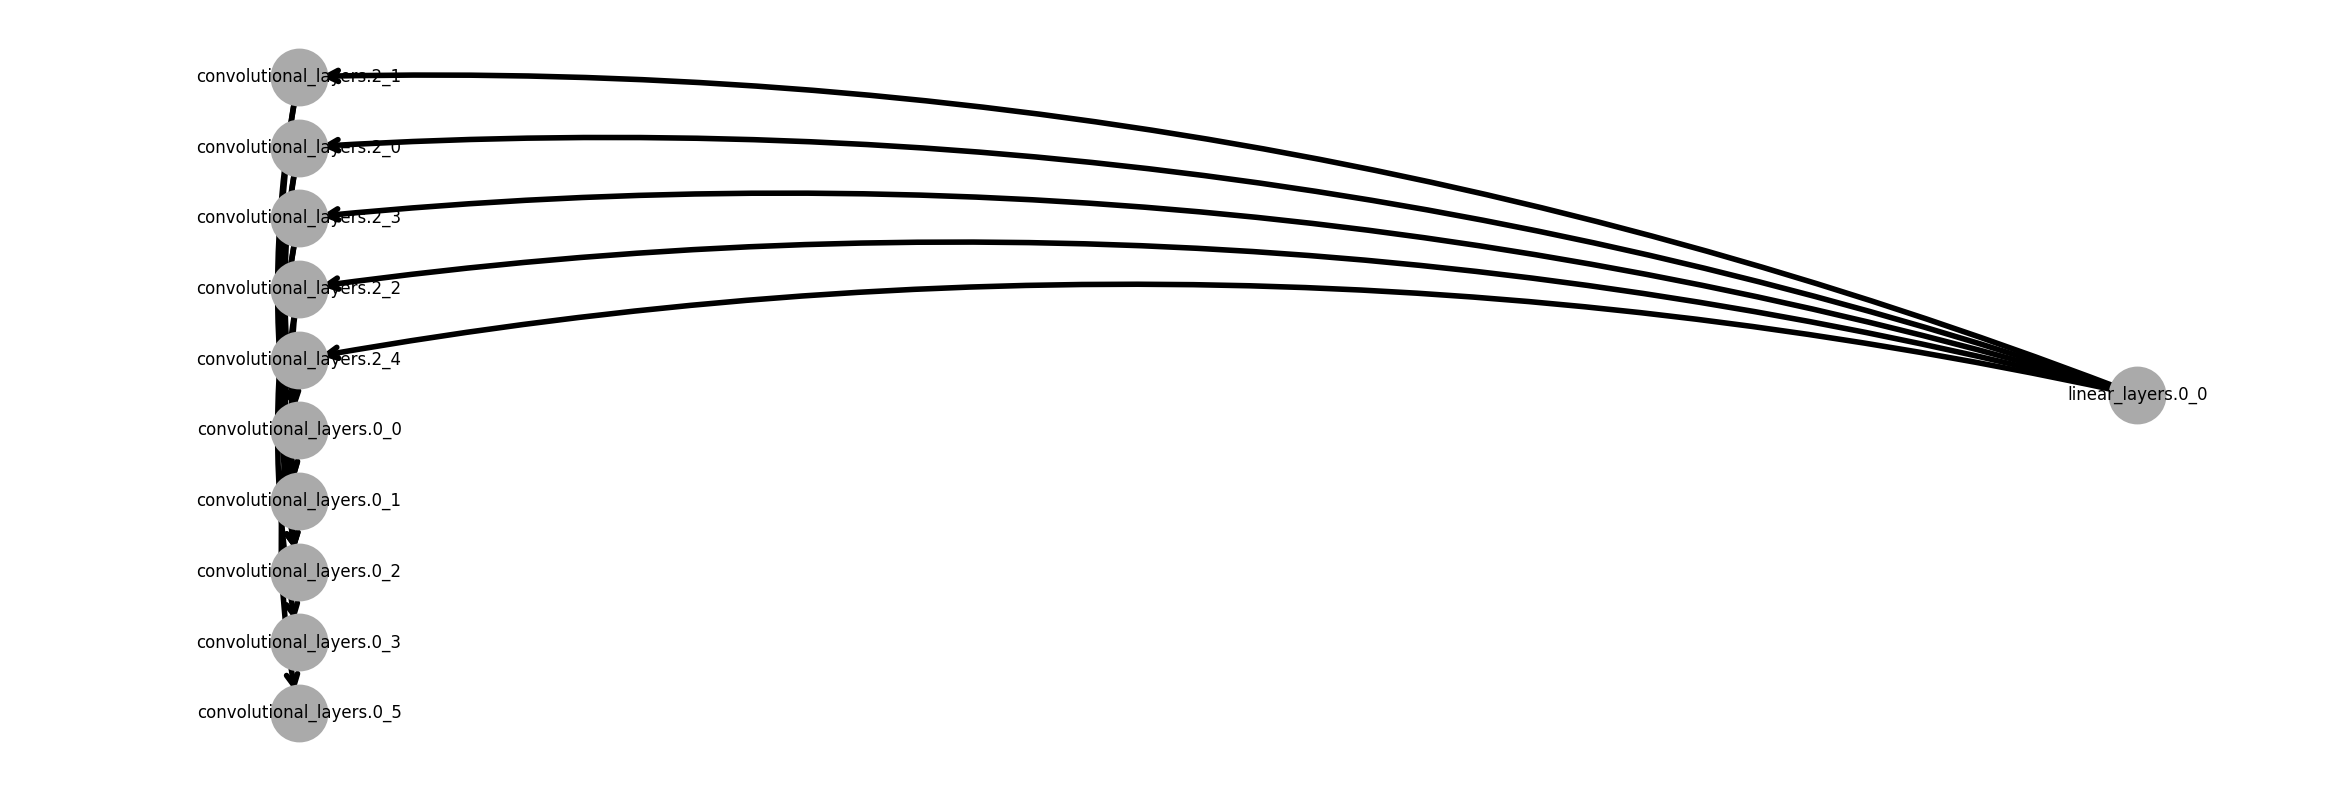